In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
fish = pd.read_csv('dataset/fish_100.csv', sep = ",")

### Calculate fatigue

In [4]:
fish['tap_count']=[1]*len(fish)
# fatigue per environment

In [5]:
tap = fish.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')

In [6]:
tap = tap.reset_index().set_index('index')
tap = tap.drop('level_0', axis =1)

In [7]:
fish = tap.merge(fish, left_index = True, right_index=True,how='inner')

### Visualization

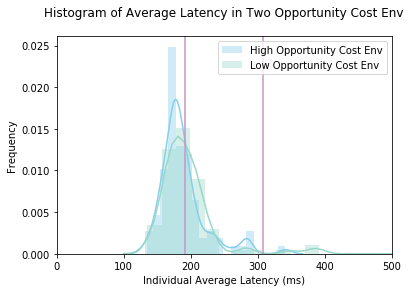

In [58]:
v = fish.groupby(['id', 'environment']).latency.mean().reset_index(name = "latency_env")
sns.distplot(v[v.environment == "high"]['latency_env'], color = 'skyblue', label = "High Opportunity Cost Env")
sns.distplot(v[v.environment == "low"]['latency_env'], color = '#99d8c9', label = "Low Opportunity Cost Env")
plt.axvline(x = 191.292, color = '#c994c7')
plt.axvline(x = 307.759, color = '#c994c7')
plt.legend()
plt.ylabel ('Frequency')
plt.xlabel('Individual Average Latency (ms)')
plt.title('Histogram of Average Latency in Two Opportunity Cost Env', pad = 20)
plt.xlim(0, 500)
plt.savefig('figure/histogram by environment.png', dpi = 300, transparent = True)

In [9]:
v.groupby('environment').mean()

,id,latency_env
environment,,
high,676423.95000,191.29626
low,676423.95000,307.75416


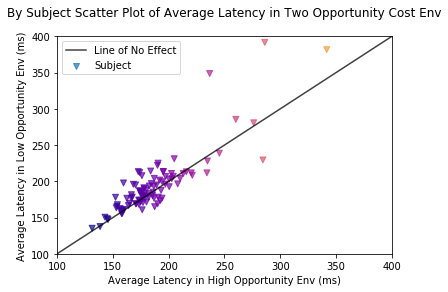

In [57]:
x = v[v.environment == "high"]['latency_env']
y = v[v.environment == "low"]['latency_env']
t = np.arange(100)
plt.scatter(x, y, alpha = 0.7, marker = 'v', c=x, cmap="plasma", label = 'Subject')
plt.title('By Subject Scatter Plot of Average Latency in Two Opportunity Cost Env', pad = 20)
plt.xlabel('Average Latency in High Opportunity Env (ms)')
plt.ylabel('Average Latency in Low Opportunity Env (ms)')
plt.ylim(100, 400)
plt.xlim(100, 400)
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, label = 'Line of No Effect')
plt.legend()
plt.savefig('figure/By Subject Scatter Plot of Average Latency in Two Opportunity Cost Env.png',bbox_inches = 'tight',
            dpi = 300, transparent = True)


### Exclusion List

In [11]:
fish = fish[~fish.id.isin([668262.0, 675528.0, 675577.0, 680119.0, 672593.0, 683242.0, 675654.0])]
# failed sound check questions 

### Missing Values

In [12]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

Checkpoint

In [13]:
len(fish.id.unique()) #93

93

### Environment + latency

In [14]:
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment_binary'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment_binary'])
fish['log_latency'] = np.log(fish['latency'])

# Why mixed model?

A linear regression model assumes the following things:
(https://www.statisticssolutions.com/assumptions-of-multiple-linear-regression/)
1. First, multiple linear regression requires the relationship between the independent and dependent variables to be linear. 
2. Second, the multiple linear regression analysis requires that the errors between observed and predicted values (i.e., the residuals of the regression) should be normally distributed. (i.i.d)
3. Third, multiple linear regression assumes that there is no multicollinearity in the data.  Multicollinearity occurs when the independent variables are too highly correlated with each other.


We measured action initiation latency multiple times for the same environment and price. Thus, the current dataset has repeated measures for the same variable, violating the second rule. 

# Why random intercept?

Everyone has a different baseline. Adding a baseline action initiation latency to everyone.

In [15]:
plot = fish.groupby(['id', 'price_displayed', 'environment'])['latency'].mean().reset_index(name = 'average_latency')


<Figure size 7200x8640 with 0 Axes>

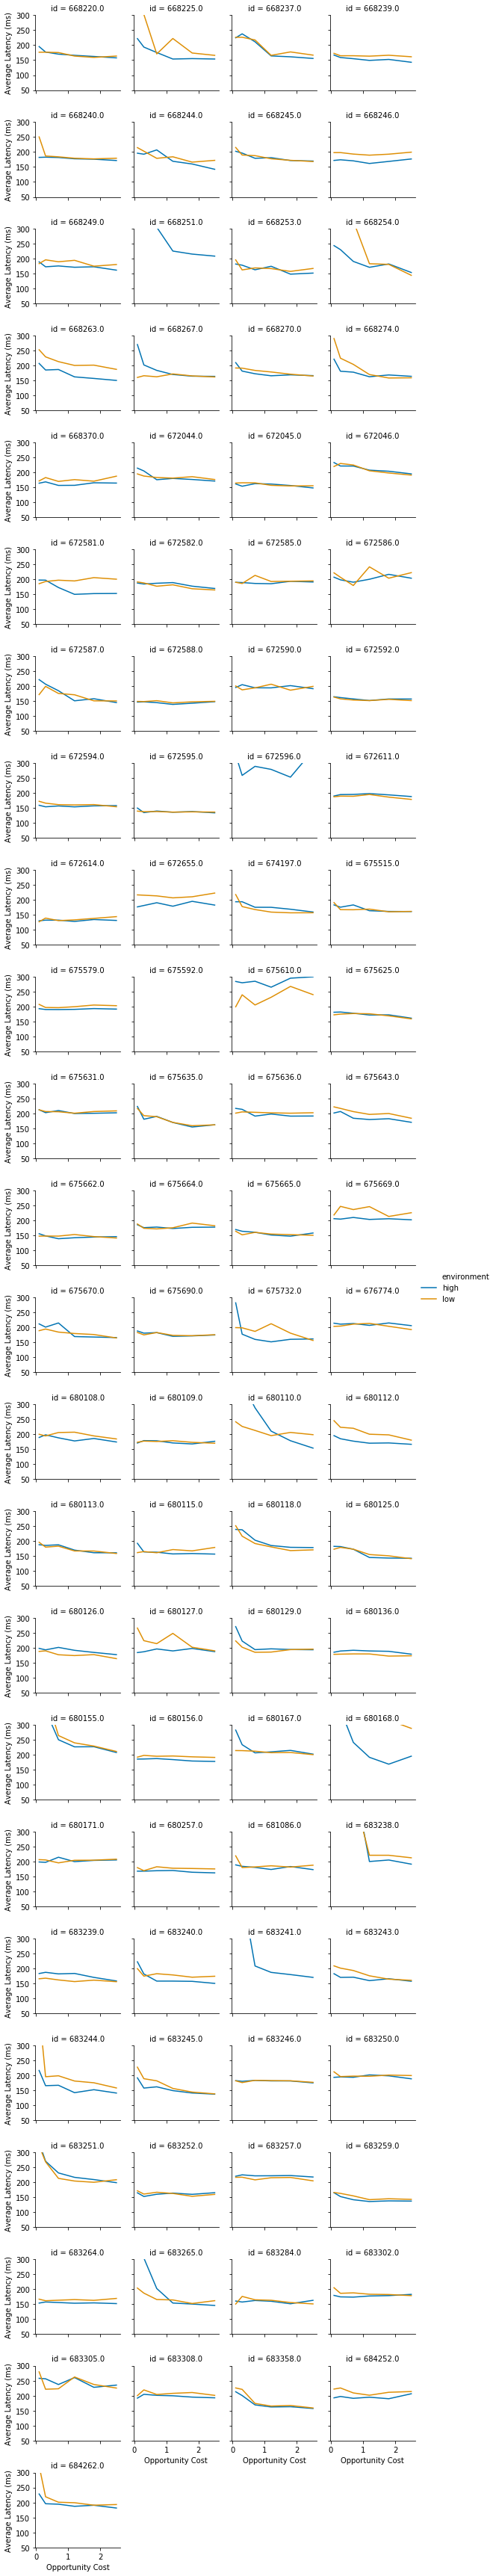

In [56]:
plt.figure(figsize=(100,120))
g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(50, 300))
g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "colorblind", legend = 'full',
      err_style="bars")
g.add_legend()
g.set_axis_labels('Opportunity Cost', 'Average Latency (ms)')
plt.savefig('Figure/By subject price and latency.png', dpi = 600, transparent = True)


In [13]:
tap_plt = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'fatigue')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


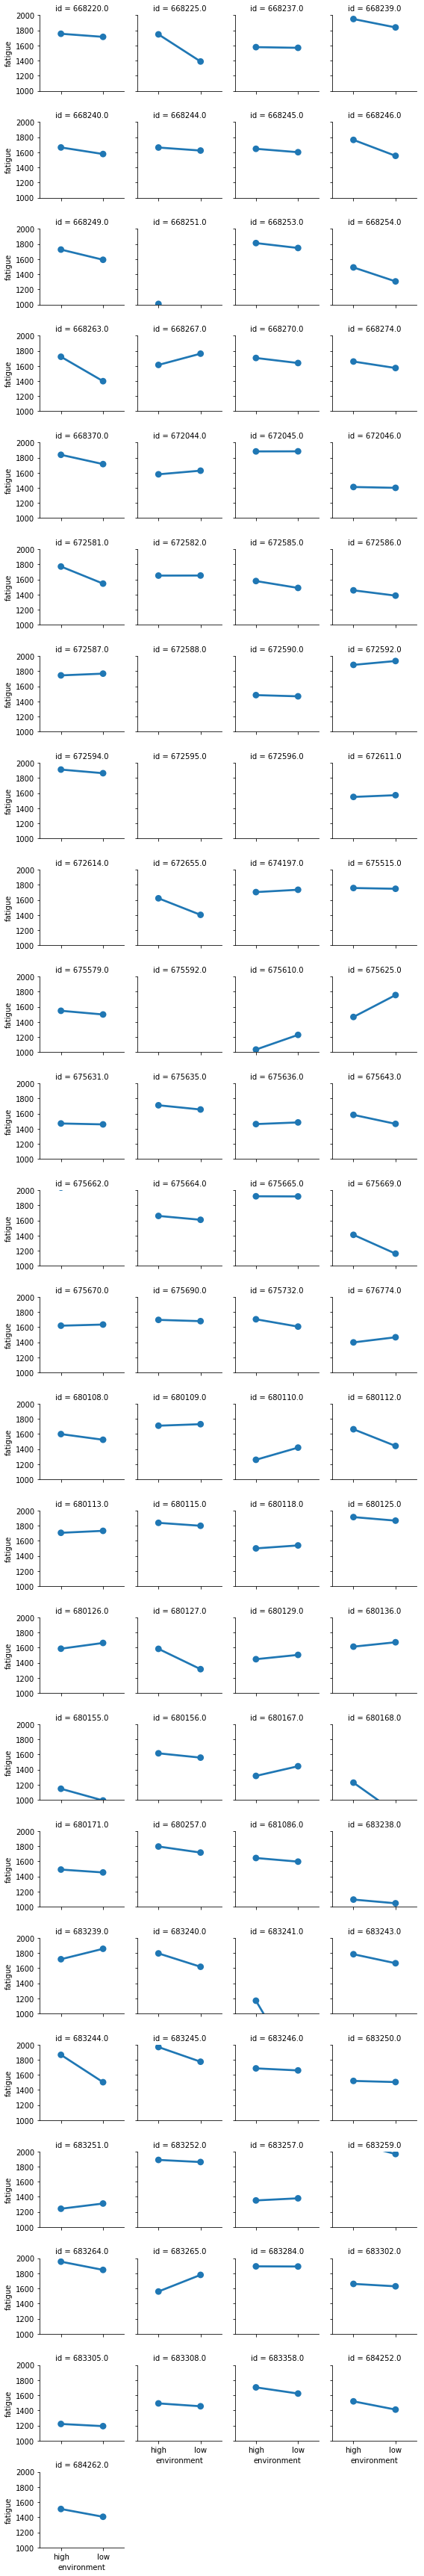

In [21]:
g = sns.FacetGrid(tap_plt, col="id", col_wrap=4, height=2, ylim=(1000, 2000))
g.map(sns.pointplot,'environment','fatigue');
g.set_axis_labels('Opportunity Cost Environment', 'Average Latency (ms)')
#sns.boxplot(x="id", y="latency", hue = 'environment_binary', data=fish)

#plt.ylim(50, 280)

# Log Linear Model

Need to pick an optimizer.
<br>Matlab uses either 'bfgs' or 'lbfgs'. But Matlab doesn't give convergence information.


In [ ]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

## Powell

In [16]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue + environment_binary*price_displayed',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'powell')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       ML         
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5837.9285  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.248    0.023 231.547 0.000  5.203  5.292
environment_binary[T.1]             

In [18]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'powell')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       ML         
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5816.9870  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.252    0.023 231.399 0.000  5.207  5.296
environment_binary[T.1]             

In [21]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [22]:
random_effects.describe()

,Group,environment_binary[T.1],price_displayed,fatigue
count,93.00000,93.00000,93.00000,93.00000
mean,-0.00000,0.00000,0.00000,-0.00000
std,0.21933,0.11312,0.06800,0.00010
min,-0.40642,-0.45865,-0.25737,-0.00014
25%,-0.12360,-0.02799,-0.02741,-0.00005
50%,-0.02854,0.02466,0.01890,-0.00002
75%,0.04441,0.05112,0.04891,0.00001
max,0.86946,0.34260,0.08173,0.00067


### Calculate AIC

In [23]:
sm.tools.eval_measures.aic(5816.9870, 295026, 4)

-11625.974

## Quasi-Newton

In [24]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'bfgs', maxiter = 100000)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       ML         
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5816.9875  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.252    0.023 231.526 0.000  5.207  5.296
environment_binary[T.1]             

In [26]:
sm.tools.eval_measures.aic(5816.9875 , 295026, 4)

-11625.975

In [27]:
sm.tools.eval_measures.bic(5816.9875, 295026, 4)

-11583.595724931874

## Compare this to matlab betas

In [29]:
matlab_beta = pd.read_csv('matlab/matlab_betas.csv', sep = ",")
matlab_beta['id']=matlab_beta['id'].astype('str')
matlab_beta.set_index('id', inplace = True)

In [30]:
matlab_beta.describe()

,environment,price
count,93.00000,93.00000
mean,0.00000,-0.00000
std,0.11149,0.06803
min,-0.46704,-0.25729
25%,-0.02858,-0.02749
50%,0.02436,0.01889
75%,0.05095,0.04897
max,0.33847,0.08179


In [31]:
betas = matlab_beta.merge(random_effects, right_index = True, left_index = True, how = 'inner')

In [32]:
betas['diff_env'] = betas['environment']- betas['environment_binary[T.1]']

In [33]:
np.sum(np.abs(betas['diff_env']))

0.11938144222576975

In [34]:
betas['diff_price'] = betas['price']- betas['price_displayed']

Text(0.5, 1.0, 'FIg2 - Random Effect: Individual Sensitivty towards Price')

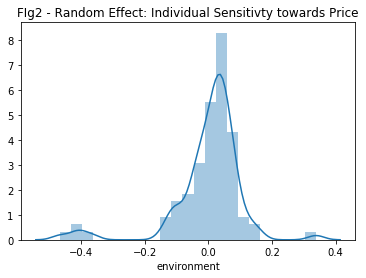

In [35]:
sns.distplot(betas['environment'])
plt.title('FIg2 - Random Effect: Individual Sensitivty towards Price')

In [36]:
len(betas[betas.environment < 0])

36

In [37]:
len(betas[betas.price < 0])

32

In [38]:
np.sum(np.abs(betas['diff_price']))

0.005398976722440127

In [40]:
fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index()['tap_count'].mean()

1586.1612903225807

## Visualization

## Random Effects

In [41]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [42]:
len(random_effects) # 93

93

In [43]:
random_effects.head(2)

,Group,environment_binary[T.1],price_displayed,fatigue
668220.0,-0.08355,0.04820,0.00370,-0.00005
668225.0,0.11717,-0.10620,-0.08723,-0.00004


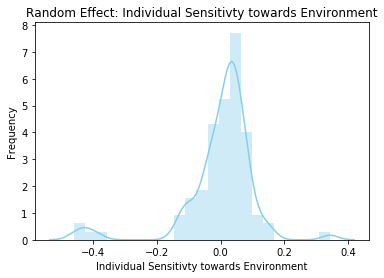

In [55]:
sns.distplot(random_effects['environment_binary[T.1]'], color = 'skyblue')
plt.title('Random Effect: Individual Sensitivty towards Environment')
plt.xlabel('Individual Sensitivty towards Environment')
plt.ylabel('Frequency')
plt.savefig('figure/Histogram for Environment Betas', transparent = True, dpi = 300)

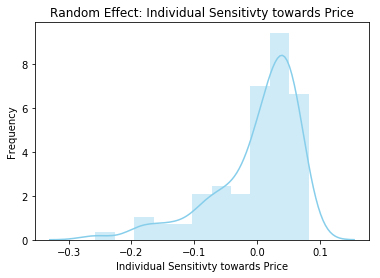

In [54]:
sns.distplot(random_effects['price_displayed'], color = 'skyblue')
plt.title('Random Effect: Individual Sensitivty towards Price')
plt.xlabel('Individual Sensitivty towards Price')
plt.ylabel('Frequency')
plt.savefig('figure/Histogram for price Betas', transparent = True, dpi = 300)

## Environment betas and tap difference

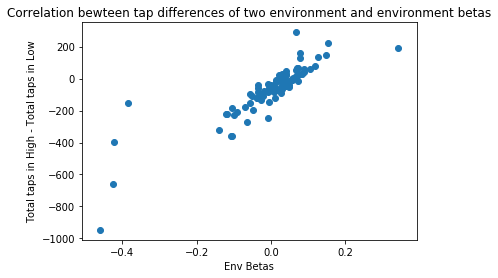

In [46]:
tap = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.title('Correlation bewteen tap differences of two environment and environment betas')
plt.xlabel('Env Betas')
plt.ylabel('Total taps in High - Total taps in Low')
plt.scatter(x, y)

In [48]:
scales = pd.read_csv('dataset/scale_fisherman_100.csv', sep = ",")
scales = scales.set_index('id')
scales = scales.drop(['Unnamed: 0'], axis = 1)
scales.index = scales.index.astype(str)
correlation_table = scales.merge(random_effects, right_index = True, left_index = True, how = 'right')

In [50]:
#correlation_table['gender'] = correlation_table['gender'].replace('Male', 0)

In [51]:
ss.spearmanr(correlation_table['depression'], correlation_table['environment_binary[T.1]'], nan_policy = 'omit')


SpearmanrResult(correlation=-0.24556966178668077, pvalue=0.018301154056350296)

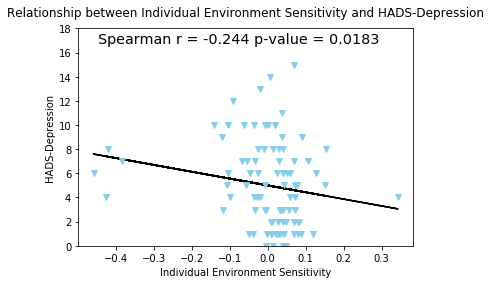

In [53]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['depression']

mask = ~np.isnan(x) & ~np.isnan(y)

slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
line = slope*x+intercept

plt.xlabel("Individual Environment Sensitivity")
plt.ylabel("HADS-Depression")
plt.ylim([0, 18])
plt.plot(x, line, color = 'black')
plt.plot(x,y,'v', color = 'skyblue')
plt.title('Relationship between Individual Environment Sensitivity and HADS-Depression', pad = 12)
plt.annotate('Spearman r = -0.244 p-value = 0.0183', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/depression_100.png', transparent=True, dpi=300, bbox_inches = 'tight')
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")